In [1]:
from genetic_program import FitnessFunction
from gp_artemis import ExperimentManager
%matplotlib inline
import pandas as pd

class WowFitnessFunction(FitnessFunction):
    _name = "ff_sowow"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent * evaluation.num_sells,

class BenchmarkDiffFitnessFunction(FitnessFunction):
    _name = "ff_benchmarkdiff"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent - evaluation.benchmark_backtest.profit_percent,
    
    
    
experiment_json = {
    "training_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/04/01 00:00:00 UTC",
        "end_time": "2018/06/01 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "validation_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/03/01 00:00:00 UTC",
        "end_time": "2018/03/31 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "fitness_function": "ff_v1",
    "grammar_version": "gv1",
    "num_generations": 3,

    "mating_probabilities": [
        0.4,
        0.5,
        0.6
    ],

    "mutation_probabilities": [
        0.7,
        0.8,
        0.9
    ],

    "population_sizes": [
        500
    ]
}

e = ExperimentManager(experiment_json, read_from_file=False)
e.run_experiments(display_results=False)


INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.8;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.9;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.5;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_

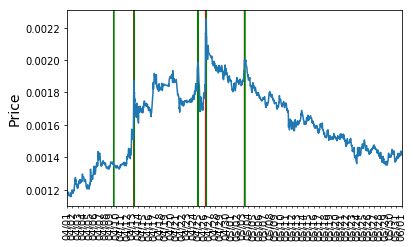

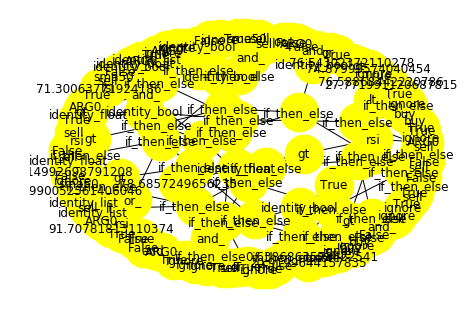

In [2]:
performance_df = e.analyze_and_find_best()

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 500)
performance_df

,abc_negative_cache_version,alpha,benchmark_profit_percent,benchmark_profit_percent_usdt,beta,buy_currency,cash,counter_currency,crypto,current_price,current_timestamp,end_cash,end_crypto,end_crypto_currency,end_price,end_time,end_value,end_value_usdt,evaluate_profit_on_last_order,evaluation,experiment_id,hof_ranking,individual,max_buy_sell_pair_gain,max_buy_sell_pair_loss,max_buy_sell_pair_return,max_drawdown,max_drawdown_duration,mean_buy_sell_pair_gain,mean_buy_sell_pair_loss,mean_buy_sell_pair_return,min_buy_sell_pair_gain,min_buy_sell_pair_loss,min_buy_sell_pair_return,num_buy_sell_pairs,num_buys,num_gains,num_losses,num_orders,num_profitable_trades,num_sells,num_trades,num_unprofitable_trades,percent_profitable_trades,profit,profit_percent,profit_percent_usdt,profit_usdt,resample_period,sharpe_ratio,slippage,source,start_cash,start_crypto,start_time,start_value,start_value_usdt,std_buy_sell_pair_gain,std_buy_sell_pair_loss,std_buy_sell_pair_return,time_delay,transaction_cost_percent,transaction_currency,verbose
64,51,0.001350,14.261649,19.364172,0.870541,OMG,0.000000,BTC,800507.153796,0.001415,1.527811e+09,0.000000,800507.153796,OMG,0.001415,1.527811e+09,1132.541511,8.470302e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,4,"[<deap.gp.Primitive object at 0x11235b3b8>, <d...",0.357875,-0.076098,0.357875,-0.372555,2847060.0,0.154426,-0.076098,0.108321,0.042410,-0.076098,-0.076098,5,6,4,1,11,4,5,11,1,0.800000,132.541511,13.254151,22.403215,1.550302e+06,60,0.210297,0,0,1000,0,1.522541e+09,1000,6920000.0,0.120566,0.000000,0.141885,0,0.0025,OMG,False
29,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,9,"[<deap.gp.Primitive object at 0x10d2d2098>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09,1000,6920000.0,0.082494,0.000000,0.093409,0,0.0025,OMG,False
20,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,0,"[<deap.gp.Primitive object at 0x10d2d2098>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09,1000,6920000.0,0.082494,0.000000,0.093409,0,0.0025,OMG,False
72,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,2,"[<deap.gp.Primitive object at 0x1135a4098>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09,1000,6920000.0,0.082494,0.000000,0.093409,0,0.0025,OMG,False
28,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,8,"[<deap.gp.Primitive object at 0x10d2d2098>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09

In [4]:
best = performance_df.iloc[0]['individual']

In [5]:
str(best)

'if_then_else(gt(identity_float(rsi(identity_list(ARG0))), sma50(identity_list(identity_list(ARG0)))), if_then_else(and_(gt(sma50(ARG0), identity_float(25.990052561406046)), lt(sma50(ARG0), identity_float(71.30063771924186))), if_then_else(and_(or_(False, True), and_(False, False)), if_then_else(and_(True, True), if_then_else(True, sell, ignore), if_then_else(True, ignore, sell)), if_then_else(identity_bool(True), if_then_else(True, ignore, sell), if_then_else(True, buy, sell))), if_then_else(gt(rsi(ARG0), identity_float(78.6857249656235)), if_then_else(lt(91.70781813110374, 99.14992698791208), if_then_else(False, sell, sell), if_then_else(False, buy, ignore)), if_then_else(lt(74.87999574040454, 76.54302372110278), if_then_else(True, buy, ignore), if_then_else(False, sell, buy)))), if_then_else(and_(and_(or_(False, True), gt(76.58868442220786, 27.771991120687815)), identity_bool(identity_bool(False))), if_then_else(gt(rsi(ARG0), rsi(ARG0)), if_then_else(or_(True, True), if_then_else(Fa

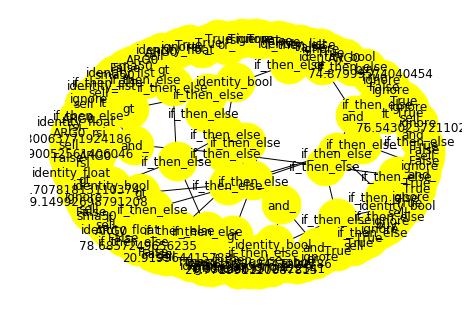

In [6]:
from chart_plotter import draw_tree
draw_tree(best)

In [7]:
print(performance_df.iloc[0].evaluation.get_report())

--

* Order execution log *

Start balance: cash = 1000 BTC, crypto = 0 
Start time: 2018-04-01 00:00:00
--
--
2018-04-09 13:00:00  	 OrderType.BUY    	 cash_balance ->      -1000.00 BTC 	 currency_balance -> 740627.993139 OMG 	 (1 OMG = 0.00134683 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-09 13:00:00 rsi_value=None
2018-04-13 04:00:00  	 OrderType.SELL   	 cash_balance ->       1354.48 BTC 	 currency_balance -> -740627.993139 OMG 	 (1 OMG = 0.00183341 BTC ), slippage = 0.00
   signal: genetic_down strength=3 trend=-1 horizon=None timestamp=2018-04-13 04:00:00 rsi_value=None
2018-04-13 06:00:00  	 OrderType.BUY    	 cash_balance ->      -1354.48 BTC 	 currency_balance -> 758977.547833 OMG 	 (1 OMG = 0.00178015 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-13 06:00:00 rsi_value=None
2018-04-24 20:00:00  	 OrderType.SELL   	 cash_balance ->       1502.79 BTC 	 currency_balance -> -758977

In [ ]:
print(performance_df.iloc[0].evaluation.benchmark_backtest.get_report())

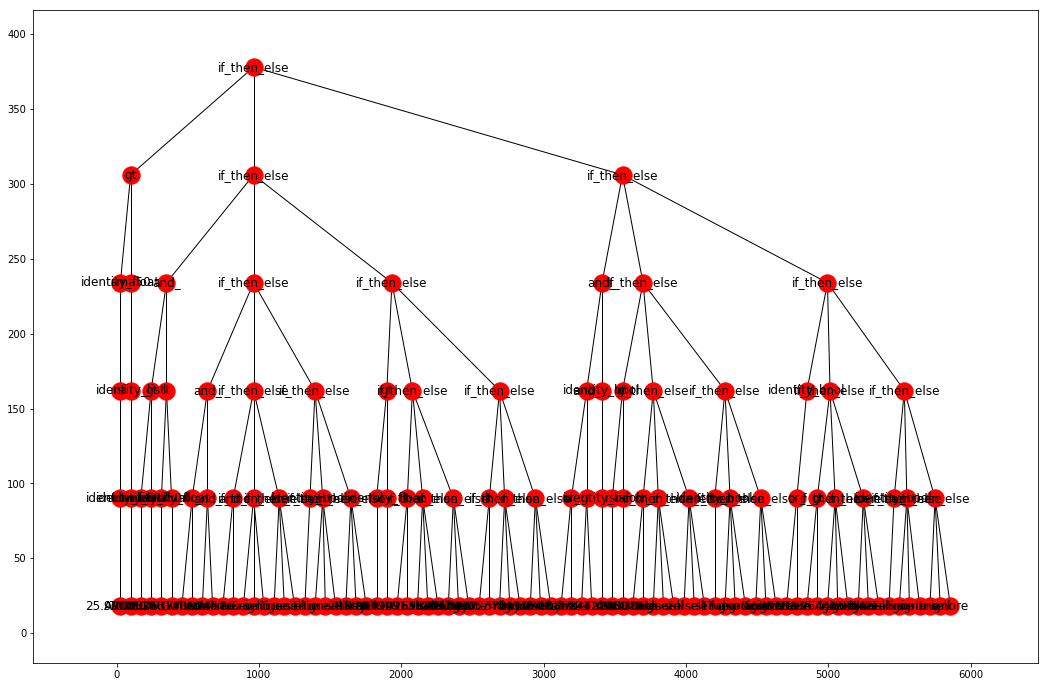

In [28]:
from deap import gp
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pylab
pylab.figure(1,figsize=(18,12))

nodes, edges, labels = gp.graph(best)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [38]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(g)
import json
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

with open('labels.json', 'w') as f:
    json.dump(labels, f, indent=4)

In [32]:
%%html

<div id="d3-container">< /div>

<style>

.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}

< /style>

In [34]:
%%javascript
// We load the latest version of d3.js from the Web.
require.config({paths: {d3: "https://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {

    // Parameter declaration, the height and width of our viz.
    var width = 300,
        height = 300;

    // Colour scale for node colours.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    // D3 has number of layouts - refer to the documentation.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(30)
        .size([width, height]);

    // We select the < div> we created earlier and add an 
    // SVG = Scalable Vector Graphics
    var svg = d3.select("#d3-container").select("svg")
    if (svg.empty()) {
        svg = d3.select("#d3-container").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }

    // We load the JSON network file.
    d3.json("graph.json", function(error, graph) {
        // Within this block, the network has been loaded
        // and stored in the 'graph' object.

        // We load the nodes and links into the force-directed
        // graph and initialise the dynamics.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a < line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");

        // We create a < circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", 5)  // radius
            .style("fill", function(d) {
                // We colour the node depending on the degree.
                return color(d.degree); 
            })
            .call(force.drag);

        // The label each node its node number from the networkx graph.
        node.append("title")
            .text(function(d) { return d.id; });



        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force.on("tick", function() {
            link.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });
        });
    });
});

<IPython.core.display.Javascript object>